# IDS Week 14_2: Text Classification with Sentence Embeddings & Logistic Regression

In this notebook, we’ll walk step-by-step through building a movie-review classifier on the Rotten Tomatoes dataset using pretrained sentence embeddings and scikit-learn’s Logistic Regression. We’ll cover:

1. **Environment Setup** – install and import libraries.  
2. **Load & Inspect Data** – load the Rotten Tomatoes reviews and take a first look.  
3. **Generate Embeddings** – encode each review into a fixed-size vector via sentence-transformers.  
4. **Train/Test Split** – partition our data for training and evaluation.  
5. **Train Classifier** – fit a Logistic Regression model on embedding features.  
6. **Evaluate Performance** – compute accuracy, confusion matrix, and classification report.  
7. **Interpret Results** – inspect model coefficients and predicted probabilities.  

## **Step 1: Environment Setup**

First, install the required libraries (`sentence-transformers` for embeddings, `datasets` for loading our data) and import everything we need.

In [ ]:
# Install sentence-transformers for easy embeddings
!pip install sentence-transformers

# Install the Hugging Face datasets library to load Rotten Tomatoes reviews
!pip install datasets

## **Step 2: Load & Inspect Data**
We’ll load the Cornell Movie Review “Rotten Tomatoes” dataset (just the training split for sample size purposes) and convert it to a pandas DataFrame for easy inspection.
- `label = 1` means "fresh"
- `label = 0` means "rotten"

In [ ]:
from datasets import load_dataset
import numpy as np
import pandas as pd

# Load the Rotten Tomatoes dataset
dataset = load_dataset("cornell-movie-review-data/rotten_tomatoes", split="train")
df = dataset.to_pandas()
df

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8525,any enjoyment will be hinge from a personal th...,0
8526,if legendary shlockmeister ed wood had ever ma...,0
8527,hardly a nuanced portrait of a young woman's b...,0
8528,"interminably bleak , to say nothing of boring .",0


In [ ]:
# Check class distribution to ensure balance
print(df['label'].value_counts(normalize=True))

label
1    0.5
0    0.5
Name: proportion, dtype: float64


## **Step 3: Generate Sentence Embeddings**
We use the `SentenceTransformer` wrapper, which exposes a simple `.encode()` method. It returns an (n_samples × embedding_dim) NumPy array.

In [ ]:
# sentence-transformers for pretrained encoder
from sentence_transformers import SentenceTransformer

# Instantiate the pretrained embedding model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

# Encode all review texts to embeddings
# convert_to_numpy=True returns a NumPy array
# show_progress_bar displays encoding progress
X_embs = embedder.encode(
    df["text"].tolist(),
    convert_to_numpy=True,
    show_progress_bar=True
)

# Inspect shape: (n_reviews, embedding_dimension)
print("Embeddings shape:", X_embs.shape)

Batches:   0%|          | 0/267 [00:00<?, ?it/s]

Embeddings shape: (8530, 384)


## **Step 4: Split into Training & Testing Sets**
We’ll hold out 20% of our embeddings/labels for testing, using a fixed random_state for reproducibility.

In [ ]:
# Define features (embeddings) and target (labels)
y = df["label"].to_numpy()

# Split embeddings and labels into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_embs,
    y,
    test_size=0.20,
    random_state=42
)

# Confirm sizes
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples:     {X_test.shape[0]}")

Training samples: 6824
Test samples:     1706


## **Step 5: Train Logistic Regression**
Fit a logistic regression classifier on our training set. We use the default L2 penalty and solver, and let `scikit-learn` choose sensible defaults.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
clf = LogisticRegression()

# Train on embedding features
clf.fit(X_train, y_train)

LogisticRegression()

## **Step 6: Evaluate Performance**
We’ll predict on the test set, compute overall accuracy, plot the confusion matrix, and print a detailed classification report (precision, recall, F1-score).

Accuracy: 0.76


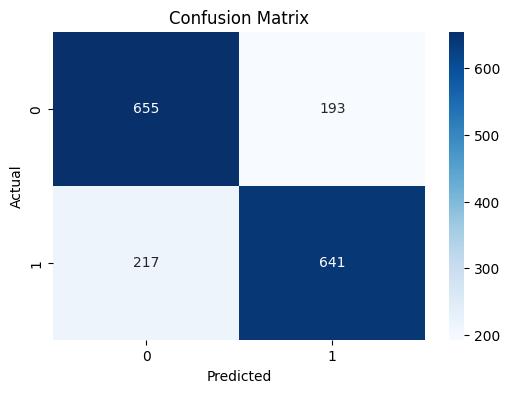

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       848
           1       0.77      0.75      0.76       858

    accuracy                           0.76      1706
   macro avg       0.76      0.76      0.76      1706
weighted avg       0.76      0.76      0.76      1706



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate and plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

## **Step 7: Predict New Texts**
Now that we have a trained model, let’s see how it does on user-supplied reviews. We’ll:

1. Define a few custom review strings.  
2. Encode them into embeddings.  
3. Predict labels and class-probabilities with our logistic regressor.  
4. Print out each review with its predicted sentiment and confidence.

In [ ]:
# 7.1 Define some new reviews to classify
new_reviews = [
    "I absolutely loved this movie, the performances were stellar!",
    "This was a terrible film; I wasted two hours of my life.",
    "The story was okay, but the pacing felt off in the second half.",
    "An underrated gem—beautiful cinematography and great score."
]

# 7.2 Generate embeddings for these new texts
# (using the same embedder we initialized earlier)
new_embs = embedder.encode(
    new_reviews,
    convert_to_numpy=True,
    show_progress_bar=False
)

# 7.3 Predict labels and probabilities
new_preds = clf.predict(new_embs)
new_probs = clf.predict_proba(new_embs)

# 7.4 Display results
for text, pred, probs in zip(new_reviews, new_preds, new_probs):
    # Map numeric label back to sentiment
    label_str = "Positive" if pred == 1 else "Negative"
    confidence = probs[pred]
    print(f"Review: {text!r}")
    print(f" → Predicted: {label_str} (confidence = {confidence:.3f})\n")

Review: 'I absolutely loved this movie, the performances were stellar!'
 → Predicted: Positive (confidence = 0.988)

Review: 'This was a terrible film; I wasted two hours of my life.'
 → Predicted: Negative (confidence = 0.937)

Review: 'The story was okay, but the pacing felt off in the second half.'
 → Predicted: Negative (confidence = 0.789)

Review: 'An underrated gem—beautiful cinematography and great score.'
 → Predicted: Positive (confidence = 0.978)

